In [48]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import argparse
from apiclient.discovery import build
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools
import datetime 

plt.style.use('fivethirtyeight')


## Initilize and Authorize Analytics API
Posted as described at https://developers.google.com/analytics/devguides/reporting/core/v4/quickstart/service-py. Please provide your own credentials file as `CLIENT_SECRETS_PATH` and your own `VIEW_ID`


In [113]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
CLIENT_SECRETS_PATH = 'oauth.json' # Path to client_secrets.json file.
VIEW_ID = '109080040'


def initialize_analyticsreporting():
# """Initializes the analyticsreporting service object.

# Returns:
# analytics an authorized analyticsreporting service object.
# """
# Parse command-line arguments.
    parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
    flags = parser.parse_args([])

    # Set up a Flow object to be used if we need to authenticate.
    flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

    # Prepare credentials, and authorize HTTP object with them.
    # If the credentials don't exist or are invalid run through the native client
    # flow. The Storage object will ensure that if successful the good
    # credentials will get written back to a file.
    storage = file.Storage('analyticsreporting.dat')
    credentials = storage.get()
    if credentials is None or credentials.invalid:
        credentials = tools.run_flow(flow, storage, flags)
    http = credentials.authorize(http=httplib2.Http())

    # Build the service object.
    analytics = build('analyticsreporting', 'v4', http=http)

    return analytics

Here are helper functions for getting and processing sessions and ecommmerce transactions data. Note `includeEmptyRows':True` instruction. This is used to get a continious time series data.

In [114]:
def get_sessions_report(analytics, n):
    # Use the Analytics Service Object to query the Analytics Reporting API V4.
    today = datetime.datetime.now()
    d = datetime.timedelta(days = n)
    a = today - d
    return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': a.strftime("%Y-%m-%d"), 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:sessions'}],
          'dimensions': [{'name':'ga:date'}]
        }]
      }
    ).execute()

def get_rate_report(analytics, n):
    today = datetime.datetime.now()
    d = datetime.timedelta(days = n)
    a = today - d
    return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': a.strftime("%Y-%m-%d"), 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:transactionsPerSession'}, ],
          'dimensions': [{'name':'ga:date'}],
          'includeEmptyRows':True
        }]
      }
    ).execute()

# helper function to process Core Reporting API Response
def response_2_fd (response):
    list = []
    # get report data
    for report in response.get('reports', []):
        # set column headers
        columnHeader = report.get('columnHeader', {})
        dimensionHeaders = columnHeader.get('dimensions', [])
        metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
        rows = report.get('data', {}).get('rows', [])

    for row in rows:
        # create dict for each row
        dict = {}
        dimensions = row.get('dimensions', [])
        dateRangeValues = row.get('metrics', [])

        # fill dict with dimension header (key) and dimension value (value)
        for header, dimension in zip(dimensionHeaders, dimensions):
          dict[header] = dimension

        # fill dict with metric header (key) and metric value (value)
        for i, values in enumerate(dateRangeValues):
          for metric, value in zip(metricHeaders, values.get('values')):
            #set int as int, float a float
            if ',' in value or '.' in value:
              dict[metric.get('name')] = float(value)
            else:
              dict[metric.get('name')] = int(value)

        list.append(dict)
    df = pd.DataFrame(list)
    return df

## Session Example
This example uses last half year sessions data (no filters/segments for a demonstrative reason) (26 * 7 days)

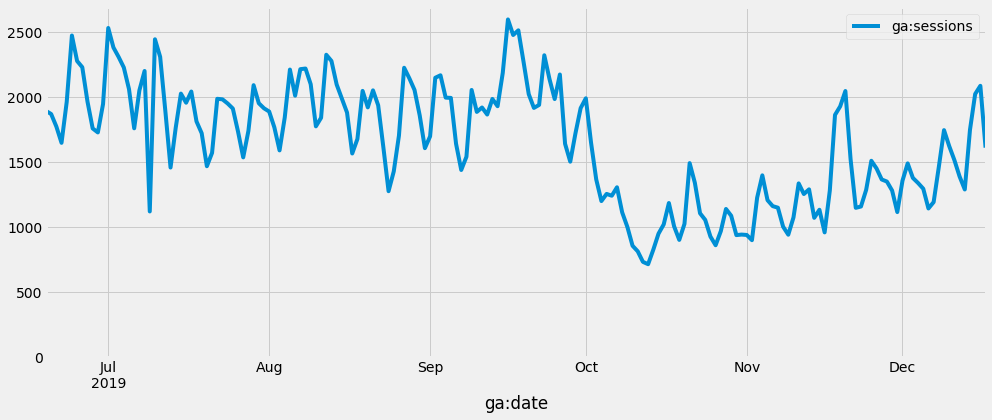

In [161]:
analytics = initialize_analyticsreporting()
response = get_report(analytics, 26*7)
df = response_2_fd(response)

# Building DateTime indexed DataFrame from GA data is pretty simple
df['ga:date'] =  pd.to_datetime(df['ga:date'])
df.set_index("ga:date", inplace = True)
df.plot(figsize=(15, 6))
plt.ylim(bottom=0)
plt.show()


Let's build a simple seasonal decomposition

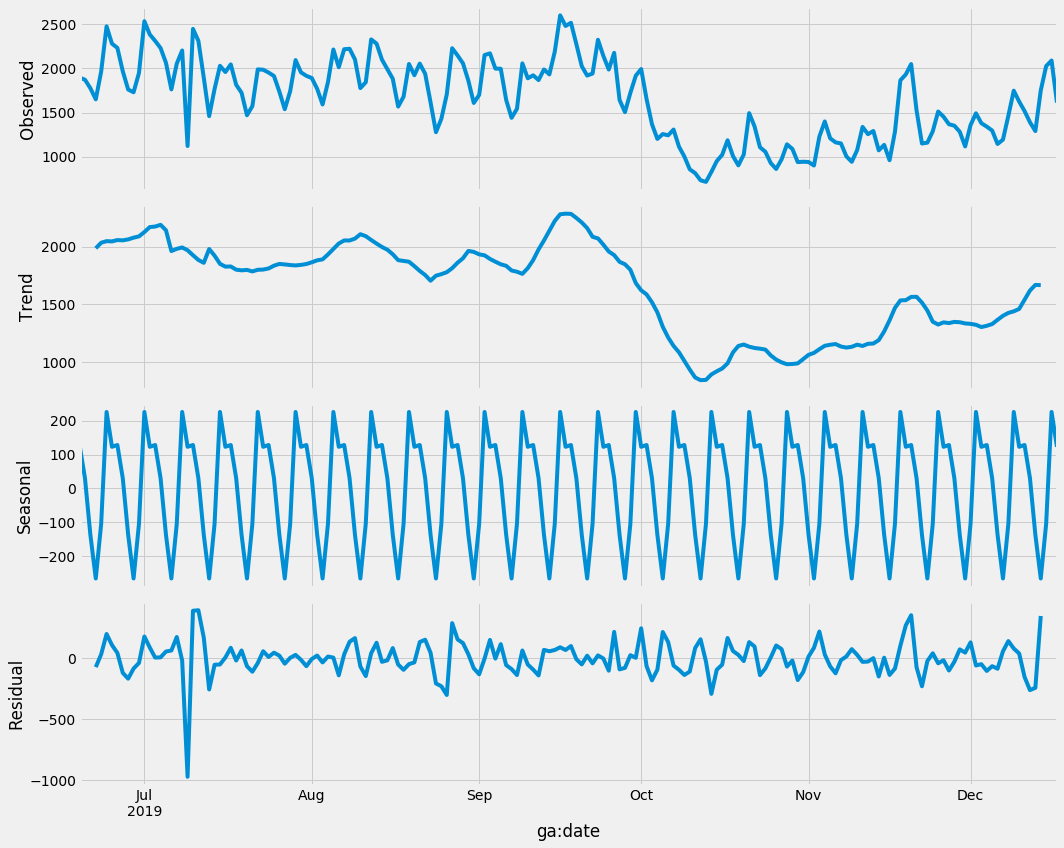

In [120]:
plt.rcParams['figure.figsize'] = 15, 12
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()


## Conversion Rate Example
This example uses last half year sessions data (no filters/segments for a demonstrative reason) (26 * 7 days)

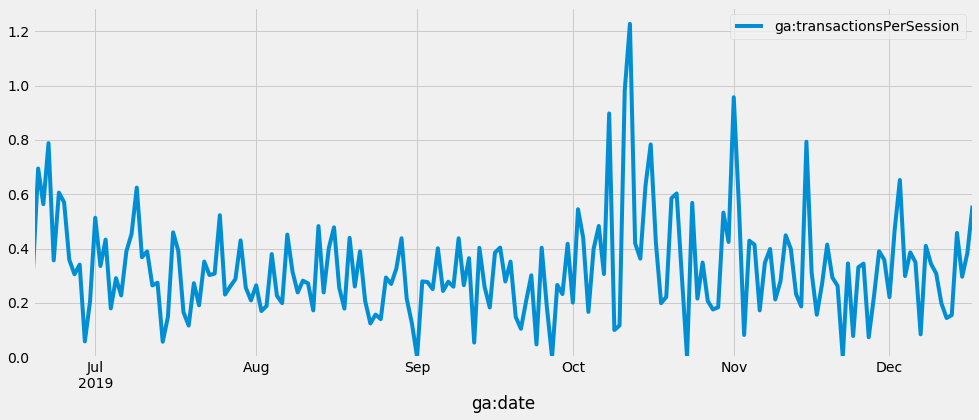

In [126]:
response_rate = get_rate_report(analytics, 26*7)
df_rate = response_2_fd(response_rate)
df_rate['ga:date'] =  pd.to_datetime(df_rate['ga:date'])
df_rate.set_index("ga:date", inplace = True)
df_rate

df_rate.plot(figsize=(15, 6))
plt.ylim(bottom=0)
plt.show()

Again, let's build a simple seasonal decomposion.
Note some monthly seasonality in general trend

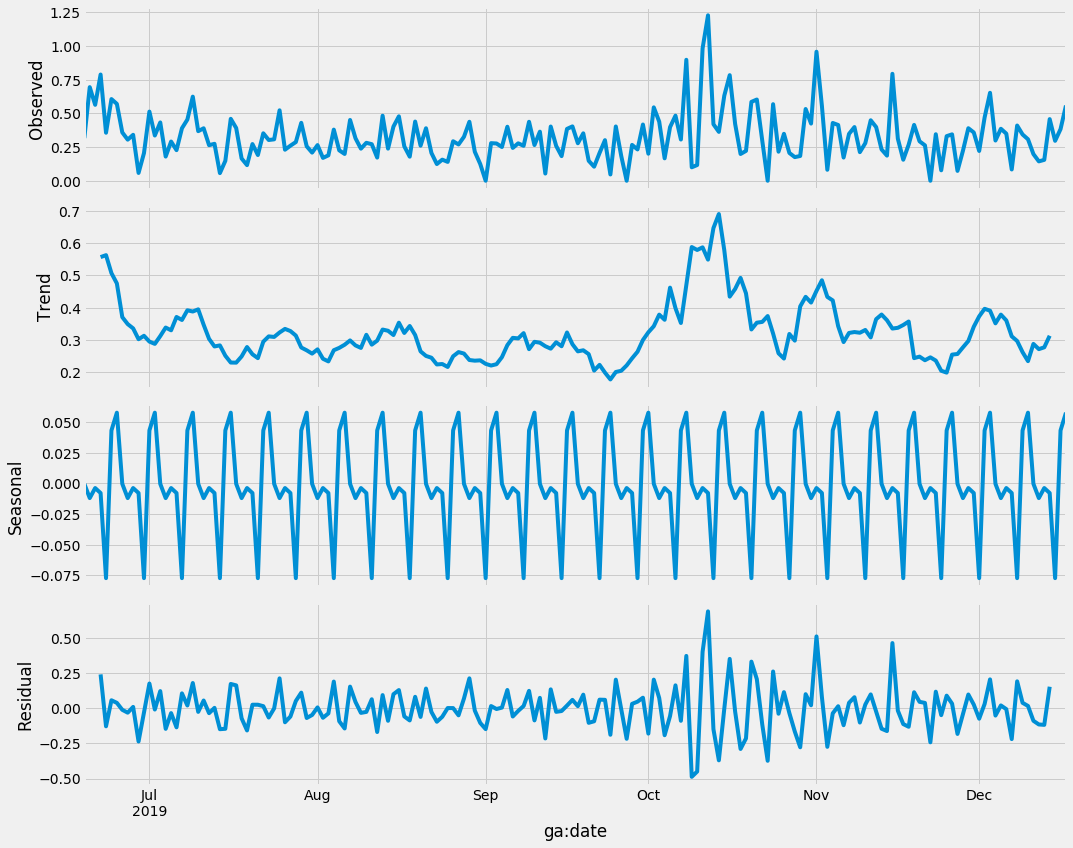

In [127]:
decomposition_rate = sm.tsa.seasonal_decompose(df_rate, model='additive') 
fig_rate = decomposition_rate.plot()
plt.show()


Some boring stuff to select ARIMA model parameters for both cases.
Copypasted from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [129]:
def fitARIMA7(df, debug = False):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore") # specify to ignore warning messages

    bm = 5000
    fparam = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                if (debug):
                    print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
                if bm > results.aic:
                    fparam = (param, param_seasonal)
                    bm = results.aic
            except:
                continue
    return fparam
print('fittest parametes for sessions:', fitARIMA7(df))
print('fittest parametes for conversion rate:', fitARIMA7(df_rate))

fittest parametes for sessions: ((1, 1, 1), (0, 1, 1, 7))
fittest parametes for conversion rate: ((0, 1, 1), (1, 0, 0, 7))


In [152]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
pred = results.get_prediction(start=pd.to_datetime('2019-11-07'), dynamic=False)

df_forecasted = pred.predicted_mean
df_observed = df['2019-11-07':]['ga:sessions']
# # Compute the mean square error
mse = ((df_forecasted - df_observed) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4866      0.118      4.108      0.000       0.254       0.719
ma.L1         -0.7534      0.117     -6.462      0.000      -0.982      -0.525
ma.S.L7       -1.1810      0.083    -14.183      0.000      -1.344      -1.018
sigma2      2.686e+04   3414.742      7.866      0.000    2.02e+04    3.36e+04
The Mean Squared Error of our forecasts is 29640.49


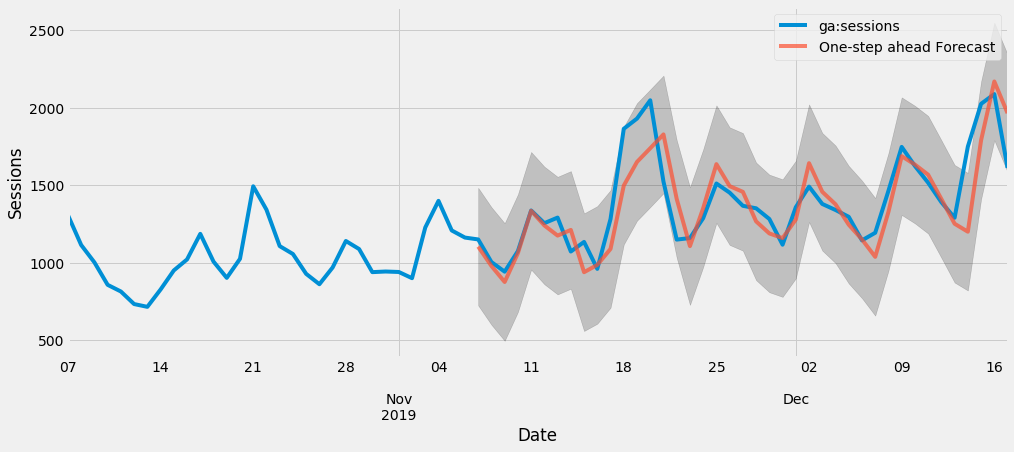

In [156]:
pred_ci = pred.conf_int()

ax = df['2019-10-07':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.rcParams['figure.figsize'] = 15, 4
plt.show()

In [159]:
mod_rate = sm.tsa.statespace.SARIMAX(df_rate,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 0, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_rate = mod_rate.fit()

print(results_rate.summary().tables[1])
pred_rate = results_rate.get_prediction(start=pd.to_datetime('2019-11-07'), dynamic=False)
df_forecasted = pred_rate.predicted_mean
df_observed = df_rate['2019-11-07':]['ga:transactionsPerSession']
# # Compute the mean square error
mse = ((df_forecasted - df_observed) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8924      0.034    -26.616      0.000      -0.958      -0.827
ar.S.L7       -0.1398      0.078     -1.795      0.073      -0.292       0.013
sigma2         0.0320      0.002     13.026      0.000       0.027       0.037
The Mean Squared Error of our forecasts is 0.03


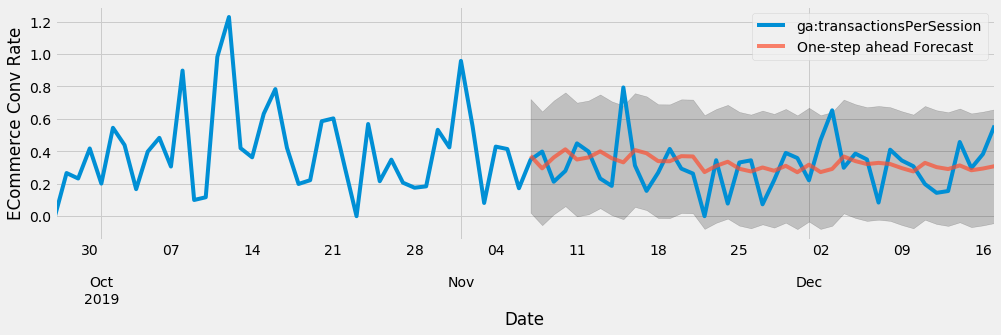

In [160]:
pred_ci_rate = pred_rate.conf_int()
ax = df_rate['2019-09-27':].plot(label='observed')
pred_rate.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_rate.index,
                pred_ci_rate.iloc[:, 0],
                pred_ci_rate.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('ECommerce Conv Rate')
plt.legend()

plt.show()